First we download all the dependencies require for this project <br/>
opencv -> used for sky detection<br/>
seaborn-> used for histogram visualizaton of pixel distribution in an image

In [1]:
!pip install opencv-python
!pip install seaborn
!pip install pandas
!pip install scipy

    100% |████████████████████████████████| 26.6MB 515kB/s eta 0:00:01
    100% |████████████████████████████████| 215kB 15.5MB/s ta 0:00:01


In [2]:
import cv2
import numpy as np
import sys
from PIL import Image, ImageFilter
import random
from scipy import spatial
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

In [15]:
file_path="tp3.jpg" ##input file path

This function is used for masking the detected sky in the image in this case we are just coloring the whole non-sky part as white with rgb value as (255,255,255)

In [4]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def make_mask(b, image): ## a function to make a white mask
    mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
    for xx, yy in enumerate(b):mask[yy:, xx] = 255
    return mask
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

This function is used for converting entire pixel to the masked value rgb (255,255,255) in our case

In [5]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def display_mask(b, image, color=(255,255,255)): ##cover the entire sky with the white mask
    result = image.copy()
    overlay = np.full(image.shape, color, image.dtype) ##overlay for translucent mask
    output=cv2.addWeighted(cv2.bitwise_and(overlay, overlay, mask=make_mask(b, image)),1,image,1,0,result)
    return output
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

"
If the input image is a colour image, we convert it into a greyscale image.
From the greyscale image, we calculate its corresponding gradient image with the Sobel operator. As is known, the Sobel operator contains two operators in the horizontal and vertical directions. We convolve the input greyscale image with these two operators and get two gradient images. Finally we calculate the gradient magnitude image by combining the two gradient images.
"[1]

In [6]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def display_cv2_image(image):
    return cv2.imencode('.png', image)[1].tostring()
def color_to_gradient(image):
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY) ## convert colored image to a black and white image
    return np.hypot(cv2.Sobel(gray, cv2.CV_64F, 1, 0),cv2.Sobel(gray, cv2.CV_64F, 0, 1))
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

"
Inspired by the energy function proposed in Ettinger S, Nechyba M, Ifju P, Waszak M (2002) Vision-Guided Flight Stability and Control for Micro Air Vehicles:
Equation 1:
<img src="1.JPG" />
where $\Sigma_s$ and $\Sigma_g$ are the covariance matrices of the pixels that are described by RGB values in sky and ground regions, respectively. They are both 3×3 matrices, which are defined as follows:

Equation 2:
<img src="2.JPG" />

Equation 3:
<img src="3.JPG" />

where Ns and Ng are the number of pixels in the sky and ground regions, respectively, while $\mu^s$ and $\mu^g$ are 3×1 column vectors that represent the average RGB values in the sky and ground regions, respectively.

$\lambda^s_i$ and $\lambda^g_i(i = \{1, 2, 3\})$ are Eigen values corresponding to the above two matrices and $|\cdot|$ denotes the determinant, that measures the variance or volume of the pixel distribution in each region.
our modified energy function is as follows:

Equation 4:
<img src="4.JPG" />
where $\gamma$ denotes our emphasis on the homogeneity in the sky region. In this paper, we choose $\gamma = 2$ experimentally. Since $|\lambda2|$ and $|\lambda3|$ are very small compared with the largest Eigen value $|\lambda1|$ of the matrix when the matrix is nearly singular, we omit the terms $\lambda2$ and $\lambda3$
"[1]

In [7]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def energy(b_tmp, image):
    sky_mask = make_mask(b_tmp, image) ##creating the mask
    ground = np.ma.array(image,mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)).compressed() ##marking the ground region
    sky = np.ma.array(image,mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)).compressed() ##marking the sky region
    ground.shape = (ground.size//3, 3) ## determining the ground shape
    sky.shape = (sky.size//3, 3) ## determining the sky shape
    sigma_g, mu_g = cv2.calcCovarMatrix(ground,None,cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    sigma_s, mu_s = cv2.calcCovarMatrix(sky,None,cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    y = 2
    return 1 / ((y * np.linalg.det(sigma_s) + np.linalg.det(sigma_g)) +(y * np.linalg.det(np.linalg.eig(sigma_s)[1]) +np.linalg.det(np.linalg.eig(sigma_g)[1])))
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

"
For a given threshold $t$, we can get $b(x)$ according to algorithm 1. Combining equations (8) and (9), the sky and ground segmentation result corresponding to $t$ can be calculated and $Jn(t)$ can be estimated without difficulty.
it is difficult to optimize $Jn(t)$ globally with the traditional gradient-based method. Fortunately, our proposed energy function $Jn(t)$ only depends on a single parameter $t$, and it is feasible to optimize it by searching in a 1D parameter space.

According to the definition of the Sobel operator, the maximum value in the gradient image is about 1,443 for a traditional 8-bit greyscale image. In theory, we have: $thresh\_min &gt; 0$ and $thresh\_max = 1443$.

But, we found that for a natural image it is unlikely that the intensity difference between the neighbouring pixels will reach 255. As a result, the maximum value of the gradient image should not be expected to reach 1,443.

we can also see that if the threshold $t$ exceeds 600, $Jn(t)$ is nearly a constant.

Considering the balance between search precision and computational complexity, we set the sampling step in the search space of $t$ as $search\_step = 5$, so that:
"[1]

In [8]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def calculate_border_optimal(image, thresh_min=5, thresh_max=600, search_step=5):
    grad = color_to_gradient(image) ##get the black and white image gradient from the colored image
    n = ((thresh_max - thresh_min) // search_step) + 1
    b_opt,jn_max = None, 0
    for k in range(1, n + 1):
        t = thresh_min + ((thresh_max - thresh_min) // n - 1) * (k - 1)
        b_tmp = calculate_border(grad, t)
        jn = energy(b_tmp, image)
        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp
    return b_opt

def calculate_border(grad, t):
    sky = np.full(grad.shape[1], grad.shape[0])
    for x in range(grad.shape[1]):
        border_pos = np.argmax(grad[:, x] > t)
        if border_pos > 0:sky[x] = border_pos
    return sky
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

"
During the image capture process, sometimes the camera is slanted or there are tall objects in the scene; there might be some image columns which do not contain a sky region.

As shown, there are fake sky regions detected in the middle of the image while directly applying the previous proposed algorithm. The reason is that our proposed algorithm implicitly assumes that there are sky region pixels in every column.

In order to overcome this drawback, we have to first detect it. Observing that there is a sudden change of sky border positions, we define the absolute differences of sky border positions:
<img src="6.JPG"/>"
[1]

In [9]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def no_sky_region(bopt, thresh1, thresh2, thresh3): ##function to cover no sky if considerable sky region is not detected
    border_ave = np.average(bopt)
    asadsbp = np.average(np.absolute(np.diff(bopt)))
    return border_ave < thresh1 or (border_ave < thresh2 and asadsbp > thresh3)

def partial_sky_region(bopt, thresh4): ##partial sky to be detected in between objetcs like pillars, openings, windows etc
    return np.any(np.diff(bopt) > thresh4)
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

This function is used to for recalculating the sky border position.

In [10]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def refine_sky(bopt, image):
    sky_mask = make_mask(bopt, image)
    ground = np.ma.array(image,mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)).compressed()
    sky = np.ma.array(image,mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)
    ret, label, center = cv2.kmeans(np.float32(sky),2,None,(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),10,cv2.KMEANS_RANDOM_CENTERS)
    sigma_s1, mu_s1 = cv2.calcCovarMatrix(sky[label.ravel() == 0],None,cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    ic_s1 = cv2.invert(sigma_s1, cv2.DECOMP_SVD)[1]
    sigma_s2, mu_s2 = cv2.calcCovarMatrix(sky[label.ravel() == 1],None,cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    ic_s2 = cv2.invert(sigma_s2, cv2.DECOMP_SVD)[1]
    sigma_g, mu_g = cv2.calcCovarMatrix(ground,None,cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    icg = cv2.invert(sigma_g, cv2.DECOMP_SVD)[1]
    if cv2.Mahalanobis(mu_s1, mu_g, ic_s1) > cv2.Mahalanobis(mu_s2, mu_g, ic_s2):
        mu_s = mu_s1
        sigma_s = sigma_s1
        ics = ic_s1
    else:
        mu_s = mu_s2
        sigma_s = sigma_s2
        ics = ic_s2
    for x in range(image.shape[1]):
        cnt = np.sum(np.less(spatial.distance.cdist(image[0:bopt[x], x],mu_s,'mahalanobis',VI=ics),spatial.distance.cdist(image[0:bopt[x], x],mu_g,'mahalanobis',VI=icg)))
        if cnt < (bopt[x] / 2):bopt[x] = 0
    return bopt
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

In [11]:
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb
def detect_sky(image): ##function to detect the sky
    bopt = calculate_border_optimal(image)
    if no_sky_region(bopt, image.shape[0]/30, image.shape[0]/4, 5):
        print("No sky detected")
        return
    output=display_mask(bopt, image)
    if partial_sky_region(bopt, image.shape[1]/3):
        bnew = refine_sky(bopt, image)
        output=display_mask(bnew, image)
    return output
## https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb

Now we will be using a 3dLUT(3 dimensional look up table). this is used for turning the image pixels a little darker by increasing the range of the blue channel in the image which makes it look that the image has been taken at night.
We are using Adobe's lookup table and this table has been taken from [2]. This lookup table has a dimension of 17x17x17 and has been named NightFromDay.CUBE

In [12]:
def load_lut(path): ##this function reads the lut file and creates a 3d lut list
    lut_dimensions=17 ##lut dimensison can be changed according to which lut we will be using
    lut3d = np.zeros((lut_dimensions**3, 3))
    with open(path, 'r') as file:
        for line_number, line in enumerate(file.readlines()[-lut_dimensions**3:]):
            line = np.array(line.strip().split(' ')).astype(np.float32)
            lut3d[line_number] = line
    return lut3d

Out here we are reading the input image as a cv2 image as thats what the primary image type is in the sky detection algorithms and functions.
We also reduce the the overall brightness of the image by setting the alpha -> 0.9 and beta -> -130 and adjust the image accordingly.

In [16]:
input_image = cv2.imread(file_path)
##reduce the brightness to -50
new_image = np.zeros(input_image.shape, input_image.dtype)
alpha = 0.9 # Simple contrast control
beta = -130    # Simple brightness control
for i in range(input_image.shape[0]):
    for j in range(input_image.shape[1]):
        for k in range(input_image.shape[2]):
            new_image[i,j,k] = np.clip(alpha*input_image[i,j,k] + beta, 0, 255)

Applying the 3d lut to the image.
So in case of a lookup table each pixel has a pre-defined designated pixel value [3]. and we just have to map the image pixels to the pixel values defined in the look up table.
The final image that we get after applying the lookup-table on the image is:
<img src="night_img.jpg" />

In [17]:
lut = np.array(load_lut("test.cube"))
img = new_image
pixels = np.array(img.reshape(-1, 3))
l1, l2, l3, l1_, l2_, l3_ = [], [], [], [], [], []
for row in range(lut.shape[0]):
    l1.append(lut[row][0])
    l2.append(lut[row][1])
    l3.append(lut[row][2])
for row in range(img.shape[0]):
    l1_.append(img[row][0])
    l2_.append(img[row][1])
    l3_.append(img[row][2])
l1,l1_ = np.array(l1),np.array(l1_) ## getting the red channel from the look-up table and the image respectively
l2,l2_ = np.array(l2),np.array(l2_) ## getting the green channel from the look-up table and the image respectively
l3,l3_ = np.array(l3),np.array(l3_) ## getting the blue channel from the look-up table and the image respectively
t1,t2,t3 = l1[l1_],l2[l2_],l3[l3_] ##transforming the image channels to look-up table channels
for row in range(img.shape[0]):
    img[row][0] = t1[row]
    img[row][1] = t2[row]
    img[row][2] = t3[row]
img = np.array(img.reshape(input_image.shape[0], input_image.shape[1], input_image.shape[2]))
cv2.imwrite("night_img.jpg", img)

True

When we run the sky detection algorithm we get a output like this:
<img src="sky.jpg" />
where the white region is the non sky and we store all the non white pixels in a list, so basically we have the entire sky region stored in a list in a pixel format now.

In [18]:
sky=detect_sky(input_image)
cv2.imwrite("sky.jpg",sky)
list_solo=[]
pil_img=Image.fromarray(np.array(sky))
for x in range(np.array(pil_img).shape[1]):
    for y in range(np.array(pil_img).shape[0]):
        if(pil_img.getpixel((x,y))==(255,255,255)):pass
        else:list_solo.append((x,y))

Now we have to introduce a gaussian noise in our imaage (only the sky region) note that this gaussian noise is monochromatic and will only consist of black and white pixels which has been distributed normally over the region.
This is how our gaussian noise over the sky region would look like:
<img src="noise.jpg"/>
Now we can see that since the sky detection algorithm that we are using is good but not 100% accuracte there is a part in the image which is actually not the sky but gets the gaussian noise
Note that we are randomly selecting half of the pixels in the sky region and then introducing the noise in it.

In [19]:
def randomly_select_points(a): ##function to random;y select half the points in the sky region
    return_list = set(random.sample(a, (len(a)-int(len(a)/1.5))))
    return_list = [i for i in a if i in return_list]  
    return return_list
list_solo=randomly_select_points(list_solo)
listt=[[255,255,255],[0,0,0]]
for coord in list_solo:
    randomize=random.sample(set([0,1]), 1)
    img[coord[1],coord[0]]=listt[randomize[0]]
cv2.imwrite("noise.jpg",img)

True

Now we use a neon filter to convolute the pixel values of the gaussian noise in order to give a sort of bright halo effect to the stars.<br/>
The neon kernel has values has been taken from [4] and the convolution code has been adapted from lab1

In [20]:
def convolution2(image,kernel_matrix,kernel_dimensions,neon_list):
    image_padded=np.zeros((image.shape[0]+kernel_dimensions-1, image.shape[1]+kernel_dimensions-1, 3)) 
    image_padded[1:-(kernel_dimensions-2), 1:-(kernel_dimensions-2)]=image 
    for element in neon_list:
        i=element[0]
        j=element[1]
        red=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 0]).sum())
        green=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 1]).sum())
        blue=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 2]).sum())
        image[j,i]=[red,green,blue]
    return image

Now we are doing is we are applying a gaussian blur kernel which has a radius of .25 pixels.<br/>
Steps to do this is: calculate the sigma from the relation:<br/>
<img src="7.png"/>
now when we get the sigma from the above equation we simply take the sigma value and plug it in [5] this will produce a 3x3 gaussian kernel matrix for us.<br/>
The next thing that we are doing is that we are clipping the grayscale histogram of the image by putting the black stop to 175 and white stop to 255.This is done by converting the rgb values to grayscale values and then putting a if condition to restrict the pixels in the image.<br/>
The code has been adopted from the convolution function implemented in lab1

True

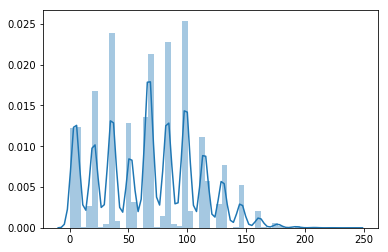

In [21]:
def convolution(original_image,image, kernel_matrix,kernel_matrix2, kernel_dimensions,kernel_dimensions2):
    image_padded=np.zeros((image.shape[0]+kernel_dimensions-1, image.shape[1]+kernel_dimensions-1, 3)) ## I'm adding kernel dimension-1 padding of zeros to the image to handle border convolution ## this generalizes it as any kernel can be used then
    image_padded[1:-(kernel_dimensions-2), 1:-(kernel_dimensions-2)]=image ##getting rest of the data from the image
    hist=[]
    neon_list=[]
    for element in list_solo:
        i=element[0]
        j=element[1]
        red=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 0]).sum())
        green=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 1]).sum())
        blue=((kernel_matrix * image_padded[j:j+kernel_dimensions, i:i+kernel_dimensions, 2]).sum())
        grayscale=(red+green+blue)/3
        hist.append(grayscale)
        if(grayscale > 175 and grayscale <255): ## restring pixels values to 175-255 as stars cannnot be too dark.
            image[j,i]=[red,green,blue]
            neon_list.append((i,j))
        else:
            image[j,i]=original_image[j,i]
    sb.distplot(hist)
#     plt.show()
    return convolution2(image,kernel_matrix2,kernel_dimensions2,neon_list)
kernel_matrix1=np.array([[0.063459, 0.124993,   0.063459],
                        [0.124993,  0.246193,   0.124993],
                        [0.063459,  0.124993,   0.063459]]) ## gaussian blur matrix of radius .25 pixels[4]
kernel_matrix_2 = np.array([[0, 1, 2, 1, 0], 
                   [1, 2, 4, 2, 1],
                   [2, 4, 8, 4, 1],
                   [1, 2, 4, 2, 1],
                   [0, 1, 2, 1, 0]]) ### neon filter [5]
cv2.imwrite('final_output.jpg',convolution(cv2.imread("night_img.jpg"),img,kernel_matrix1,kernel_matrix_2,3,5))

The fianl output image will look like:<br/>
<img src="gaussian_blured.jpg" />

Note that as stated in the interim project report this idea is inspired by [6] and we are just trying to replicate the steps in [6]<br/>
since in photoshop this is a lengthy process we are tying to automate is as much as we can, as this type of process is used more and more in creating magzines pictures purely based on imagination and no training data.<br/>
For future scope one can try detecting street lights, windows, tail-lights and head lights of cars and try to light them up. This is a difficult task as there are thousand different types of light poles, cars, window shapes, window alignments etc. So that the range of images given as input to this project can be increased.

Limitations:<br/>
-> this approach does not light up street lights, or windows so this approach does not work well on city images but works well on landscape images or monument images<br/>
-> there is a possible loss of bright pixels in areas which are covered by shadows. So when we are trying to reduce the brightness of the image and then apply a 3dlut on it that area

Some other outputs: <br/>
<h2>Input Image:</h2>                                   
<img src="input1.jpg">
<h2>Output Image:</h2>  
<img src="output1.jpg"><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input2.jpg">
<h2>Output Image:</h2>  
<img src="output2.jpg"><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input3.jpg">
<h2>Output Image:</h2>  
<img src="output3.jpg"><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input4.jpg">
<h2>Output Image:</h2>  
<img src="output4.jpg"><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input5.jpg">
<h2>Output Image:</h2>  
<img src="output5.jpg" ><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input6.jpg">
<h2>Output Image:</h2>  
<img src="output6.jpg"><br/><br/>

<h2>Input Image:</h2>                                   
<img src="input7.jpg">
<h2>Output Image:</h2>  
<img src="output7.jpg"><br/><br/>

Reference:
[1] https://github.com/cnelson/skydetector/blob/master/sky_detection.ipynb <br/>
[2] https://github.com/picwellwisher12pk/Presets/blob/master/3DLUTs/NightFromDay.CUBE   <br/>
[3] https://en.wikipedia.org/wiki/3D_lookup_table<br/>
[4] https://stackoverflow.com/questions/12008493/create-a-halo-around-text-in-python-using-pil  <br/> 
[5] http://dev.theomader.com/gaussian-kernel-calculator/   <br/>